# Setup
including loading packages, defining helper plotting functions, and generating subfigures

NOTE: necessary to run if you are running anything else in this notebook

In [4]:
%load_ext autoreload
%autoreload 2

import argparse
import sys
import os

import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image, ImageDraw, ImageFont

from src import secondlevel_group_glm
from src import secondlevel_group_encoding
from src import secondlevel_individual_encoding
from src import helpers
from src import plotting_helpers

load = True #set load=True to load analysis files (need to have downloaded them beforehand). False will run all analyses before plotting them (will take longer)
generate_subfigures = True # will take much longer than downloading the subfigures to use in making the main figures
base_dir = '../' #automatically uses this project directory, can be set to a different location

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_default_args(base_dir):
	args_dict = { 
				'model': None,
				'task':	'sherlock',
				'mask':	'ISC',
				'perc_top_voxels':	5,
				'space': 'MNI152NLin2009cAsym',
				'smoothing_fwhm': 3.0,
				'chunklen': 20,
				'population': 'NT',
				'feature_of_interest': None,
				'ISC_type':'leave_one_out',
				'dir': base_dir,
				'out_dir': os.path.join(base_dir,'analysis'),
				'figure_dir': os.path.join(base_dir,'figures','subfigures')
			}
	return args_dict
def construct_args(args_dict):
	parser = argparse.ArgumentParser()
	parser.add_argument('--model','-model',type=str,default=args_dict['model'])
	parser.add_argument('--task','-task',type=str,default=args_dict['task'])
	parser.add_argument('--mask','-mask',type=str, default=args_dict['mask']) #the mask that contains all masks of interest (overarching mask )
	parser.add_argument('--perc-top-voxels','-perc-top-voxels',type=int,default=args_dict['perc_top_voxels'])
	parser.add_argument('--space','-space',type=str,default=args_dict['space'])
	parser.add_argument('--smoothing-fwhm','-smoothing-fwhm',type=float,default=args_dict['smoothing_fwhm'])
	parser.add_argument('--chunklen','-chunklen',type=int,default=args_dict['chunklen'])
	parser.add_argument('--population','-population',type=str,default=args_dict['population'])
	parser.add_argument('--feature-of-interest','-feature-of-interest',type=str,default=args_dict['feature_of_interest'])
	parser.add_argument('--ISC-type','-ISC-type',type=str,default=args_dict['ISC_type'])

	parser.add_argument('--dir', '-dir', type=str,
						default=args_dict['dir'])
	parser.add_argument('--out_dir', '-output', type=str,
						default=args_dict['out_dir'])
	parser.add_argument('--figure_dir', '-figures', type=str,
						default=args_dict['figure_dir'])
	def filter_jupyter_args(args):
		# Filter out any args starting with --f= (Jupyter passes --f=<file>)
		return [arg for arg in args if not arg.startswith('--f=')]
	filtered_args = filter_jupyter_args(sys.argv)
	args = parser.parse_args(filtered_args[1:])  # [1:] to skip the script name
	return args

def plot_secondlevel_group_glm(base_dir,task,cmap='gray_inferno'):
	args_dict = get_default_args(base_dir)
	args_dict['task']=task
	args_dict['mask']=None
	args = construct_args(args_dict)

	### GROUP ANALYSIS
	secondlevel_group = secondlevel_group_glm.SecondLevelGroup(args)
	secondlevel_group.do_stats = False

	secondlevel_group.compile_data()
	# secondlevel_group.plot_weights()
	secondlevel_group.plot_zscores(vmin=0,FDR_correction=True, threshold=0.01,symmetric_cbar=False,cmap=cmap) #
def plot_secondlevel_group_encoding(base_dir,model,plotting,feature_names,cmap='gray_inferno',diff_cmap='',mask='ISC',load=False,vmax=None):
	args_dict = get_default_args(base_dir)
	args_dict['model']=model
	args_dict['mask'] = mask
	args_dict['mask_name'] = mask
	if(model=='correlation'):
		args_dict['smoothing_fwhm'] = 6.0

	args = construct_args(args_dict)

	### GROUP ANALYSIS
	secondlevel_group = secondlevel_group_encoding.SecondLevelGroup(args)
	secondlevel_group.do_stats = False
	secondlevel_group.explainable_variance_mask = False
	secondlevel_group.feature_names = feature_names
	secondlevel_group.scale_by=''#'total_variance'
	if(not load):
		secondlevel_group.compile_data(measures=['performance']+plotting) #always need to do performance to get proper brain shape and affine
	if('preference_map' in plotting):
		secondlevel_group.compute_preference_maps(restricted=False)
	secondlevel_group.save_results()
	if('performance' in plotting):
		title = ''
		if(model=='correlation'):
			secondlevel_group.permutation_brainiak(load=load)
			title='Intersubject Correlation'
		else:
			secondlevel_group.stats_wilcoxon()
			title = 'Joint Encoding Model Performance'
		secondlevel_group.plot_performance('stats',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap,title=title)
	if('ind_product_measure' in plotting):
		secondlevel_group.stats_wilcoxon()
		secondlevel_group.plot_ind_product_measure('stats',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('added_variance' in plotting):
		secondlevel_group.plot_added_variance('raw',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('unique_variance' in plotting):
		secondlevel_group.plot_unique_variance('raw',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('spatial_correlation' in plotting):
		secondlevel_group.plot_spatial_correlation('raw',threshold=None,vmin=None,vmax=vmax,cmap=cmap)
	if('ind_feature_performance' in plotting):
		secondlevel_group.plot_ind_feature_performance('raw',threshold=0.01,vmin=0,vmax=vmax,cmap=cmap)
	if('preference_map' in plotting):
		secondlevel_group.plot_preference_maps(label='both')
	if('difference' in plotting):
		secondlevel_group.plot_difference('raw',threshold=0.01,cmap=diff_cmap,vmax=vmax)
def get_secondlevel_individual(base_dir, model):
	args_dict = get_default_args(base_dir)
	args_dict['model']=model
	args = construct_args(args_dict)

	secondlevel_ind = secondlevel_individual_encoding.SecondLevelIndividual(args)
	secondlevel_ind.localizer_contrasts = {'SIpointlights':{'interact&no_interact','interact-no_interact'},'social interaction':{'interact&no_interact','interact-no_interact'},'language':{'intact-degraded'}}
	
	## specifying the names of each mask
	MT = ['MT']
	ISC = ['ISC']
	STS = ['pSTS','aSTS']#'frontal_language']
	language =['pTemp','aTemp']#,'frontal_language']
	language_ROI_names = ['pTemp','aTemp']#,'frontal']
	secondlevel_ind.localizer_masks = {'interact&no_interact':MT,'interact-no_interact':STS,'intact-degraded':language, 'degraded-intact':STS,
							'motion pointlights':MT,'SI pointlights':STS, 'language':language, 'DMN':STS,
							'social interaction':STS,'social':STS,
       						'GPT2':STS,'sbert':language,'sbert+word2vec':language,'word2vec':language,'hubert':language,
							'motion':MT,'num_agents':STS, 'alexnet':STS,'alexnet':STS,
							'valence':STS,'face':STS,'mentalization':STS, 'arousal':STS,
							'speaking':STS,'indoor_outdoor':STS,
							'turn_taking':STS,'written_text':STS,'music':STS,'none':STS}
	secondlevel_ind.MT = MT
	secondlevel_ind.ISC = ISC
	secondlevel_ind.STS = STS
	secondlevel_ind.language = language
	secondlevel_ind.language_ROI_names = language_ROI_names
	return secondlevel_ind

In [6]:
#load the default arguments for easy access
args_dict = get_default_args(base_dir)
subject = 'sub-33' #specifying representative subject #sub-26, sub-39 are other options

In [8]:
def label_brain_plots(output_filename, final_image, labels_dict={}, desc_dict={}, feature_names=[], features_on_width=True,pad_prop=0,include_desc=True,include_ind_group_labels=True,color_dict=None):
    # add padding for the labels
    pad = 200
    if features_on_width:
        padding = (pad, pad, pad, pad)
    else:
        padding = (pad, pad, pad, 0)
    
    new_width = final_image.width + padding[0] + padding[2]
    new_height = final_image.height + padding[1] + padding[3]

    new_image = Image.new('RGBA', (new_width, new_height), (255, 255, 255, 0))
    new_image.paste(final_image, (padding[0], padding[1]))

    draw = ImageDraw.Draw(new_image)
    font = ImageFont.truetype("Arial Bold.ttf", 85)
    label_font = ImageFont.truetype("Arial Bold.ttf", 125)  # Larger font for 'Individual' and 'Group'
    width, height = final_image.size
    
    if features_on_width:
        portion = width // len(feature_names)
        centers = [(portion * i + portion // 2.35, 15) for i in range(len(feature_names))]
    else:
        portion = height // len(feature_names)
        centers = [(new_width // 2, (portion * i)-pad_prop*portion/3) for i in range(len(feature_names))]
    
    text_padding = 25
    if(len(feature_names)>1):
        for center, feature in zip(centers, feature_names):
            bbox = draw.textbbox((0, 0), labels_dict[feature], font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
            
            if features_on_width:
                text_x = center[0] - (text_width // 2) + pad
                text_y = center[1] + (text_height // 2)
                rectangle_x = center[0] - portion // len(feature_names)
                rectangle_coords = (
                    rectangle_x + pad,                # Left
                    text_y - text_padding,                     # Top
                    rectangle_x + (portion//len(feature_names)*2) +pad ,        # Right
                    text_y + text_padding*5      # Bottom
                    )
            else:
                text_x = center[0] - (text_width // 2)
                text_y = center[1] - (text_height // 2) + pad
                rectangle_x = center[0] - (text_width //2)
                rectangle_coords = (
                    rectangle_x - pad,                # Left
                    text_y - text_padding,                     # Top
                    rectangle_x + text_width+pad ,        # Right
                    text_y + text_padding*5      # Bottom
                    )
            
            draw.rounded_rectangle(rectangle_coords, radius=30, width=10,fill='lightgray')
            draw.text((text_x,text_y), labels_dict[feature], fill="black", font=font)
            
            if(include_desc):
                bbox = draw.textbbox((0, 0), desc_dict[feature], font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                
                if features_on_width:
                    text_x = center[0] - (text_width // 2) + pad
                    text_y = new_image.size[1] - text_height * 1.6
                else:
                    text_x = center[0] - text_width // 2
                    text_y = center[1]  + portion
                
                draw.text((text_x, text_y), desc_dict[feature], fill="black", font=font)
            
    
    if(include_ind_group_labels):
        if features_on_width:
            #rotated labels for labeling Individual and Group brain maps
            for y,text in zip((1,3),['Individual','Group']):
                bbox = draw.textbbox((0, 0), text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                text_image = Image.new('RGBA', (text_width,text_height+20), (255, 255, 255, 0)) #transparent background
                draw = ImageDraw.Draw(text_image)
                text_position = (0,0)
                draw.text(text_position, text, font=font, fill="black")
                text_image = text_image.rotate(90, resample=Image.BICUBIC, expand=1)
                new_image.paste(text_image, (-15, (final_image.size[1]//4)*y), text_image)
        else:
        # Labels for 'Individual' and 'Group' along the top
            label_positions = [(0.24, 'Individual'), (0.7, 'Group')]
            for pos, text in label_positions:
                bbox = draw.textbbox((0, 0), text, font=label_font)
                text_width = bbox[2] - bbox[0]
                text_x = int(new_image.size[0] * pos - text_width / 2)
                text_y = new_height - (pad)
                draw.text((text_x, text_y), text, font=label_font, fill="black")

    new_image.save(output_filename)
    return new_image

# Main Figures
NOTE: you can run these if you cloned the GitHub repository and ran Setup (above). 

### Main Figure 1C (layer averaged feature similarity of specific vision and language features during movie)

In [4]:
##MAIN
secondlevel_ind = get_secondlevel_individual(base_dir,'joint')
#only display some of the features
secondlevel_ind.feature_names =  ['alexnet_layer'+str(layer) for layer in [1,2,3,4,5,6,7]] +['motion','social'] + ['hubert_layer'+str(layer) for layer in [1,2,3,4,5,6,7,8,9,10,11,12]] + ['word2vec'] + ['sbert_layer'+str(layer) for layer in [1,2,3,4,5,6,7,8,9,10,11,12]] 
results_matrix = compile_featurespace_correlation_results(secondlevel_ind)
output_filename = os.path.join(secondlevel_ind.dir,'figures','main',f'featurespace_correlation_layers_averaged.png')
plot_featurespace_correlation(secondlevel_ind,results_matrix,output_filename,average_over_layers=True)
print('layer averaged similarity matrix saved: ', output_filename)

NameError: name 'get_secondlevel_individual' is not defined

### Main Figure 2. Intersubject correlation and encoding model performance group maps

In [21]:
images = []

argument_list = ['chunklen'] #arguments to include in the filename
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup','performance')
post_filepath = '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
images.append(os.path.join(base_filepath,f"sub-{args_dict['population']}_brain2brain_correlation_smoothingfwhm-6.0_{post_filepath}_measure-perf_stats.png"))

argument_list = ['smoothing_fwhm','chunklen','mask'] #arguments to include in the filename
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup','performance')
post_filepath = '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
images.append(os.path.join(base_filepath,f"sub-{args_dict['population']}_encoding_model-joint_{post_filepath}_measure-perf_stats.png"))

argument_list = ['smoothing_fwhm','chunklen','mask'] #arguments to include in the filename
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup','ind_product_measure')
post_filepath = 'sub-NT_encoding_model-joint_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
images.append(os.path.join(base_filepath,post_filepath+'_measure-ind_product_measure_stats_feature-alexnet_vmax-0.13.png'))

argument_list = ['smoothing_fwhm','chunklen','mask'] #arguments to include in the filename
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup','ind_product_measure')
post_filepath = 'sub-NT_encoding_model-joint_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
images.append(os.path.join(base_filepath,post_filepath+'_measure-ind_product_measure_stats_feature-sbert_vmax-0.13.png'))

output_filename = os.path.join(args_dict['dir'],'figures','main',f'encoding_model_group_maps.png')
final_image = plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=2,row_padding_proportion=0.15,label_subplots=True)

print('intersubject correlation and encoding model brain maps saved:', output_filename)

intersubject correlation and encoding model brain maps saved: /Users/hsmall2/Documents/GitHub/naturalistic-multimodal-movie/figures/main/encoding_model_group_maps.png


### Main Figure 3. Joint model variance decomposition

In [ ]:
## create subfigure of the representative preference maps
argument_list = ['smoothing_fwhm','chunklen']
images = []
for subject in ['sub-32','sub-61']: #sub-33',,'sub-62'
    base_filepath = subject+'_encoding_model-joint_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list])
    images.append(os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','preference_map',base_filepath+'_measure-ind_product_measure_preference1_map_all.png'))
argument_list = ['smoothing_fwhm','chunklen','mask','model']
color_dict = {}

output_filename = os.path.join(args_dict['dir'],'figures','main',f'joint_preference_map.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,color_dict=color_dict,num_columns=1, row_padding_proportion=0.15)

## compile into full figure with the ROI barplot
images = []
argument_list = ['smoothing_fwhm','chunklen','mask']
base_filepath = 'sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list])
images.append(os.path.join(args_dict['dir'],'figures','main','joint_preference_map.png'))
images.append(os.path.join(args_dict['figure_dir'],'SecondLevelIndividual',base_filepath+'_model-joint_glm_localizer_enc_response-ind_product_measure_perc_top_voxels-'+str(args_dict['perc_top_voxels'])+'__all_stacked.png'))
output_filename = os.path.join(args_dict['dir'],'figures','main',f'joint_product_measure.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=2,label_subplots=True)
print('variance decomposition figure saved:',output_filename)

### Main Figure 4. AlexNet prediction across regions

In [ ]:
images = []
argument_list = ['smoothing_fwhm','chunklen','mask']
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list]))
images.append(f'{base_filepath}_model-joint_glm_localizer_enc_response-ind_product_measure_perc_top_voxels-{args_dict["perc_top_voxels"]}_bar_DNN_layers_alexnet_layers_hemis_averaged.png')

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','response_similarity','sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list]))
images.append(f'{base_filepath}_model-vislang_weights_response_similarity_perc_top_voxels-{args_dict["perc_top_voxels"]}-alexnet_similarity_matrix_layer6_hemis_averaged.png')
output_filename = os.path.join(args_dict['dir'],'figures','main',f'AlexNet_split_hemi.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=2,label_subplots=True,row_padding_proportion=0.1)
print('alexnet layerwise predictivity and weight similarity figure saved:',output_filename)

### Main Figure 5. Most predictive AlexNet units

In [85]:
images = []
images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/unit_interpretations/highlighted_alexnet_layer6_unit-383.png'))
images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/unit_interpretations/highlighted_alexnet_layer6_unit-3764.png'))

# images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/unit_interpretations/highlighted_alexnet_layer6_unit-2513.png'))
images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/unit_interpretations/highlighted_alexnet_layer6_unit-1138.png'))

output_filename = os.path.join(args_dict['dir'],'figures','main',f'unit_interpretations.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=1,label_subplots=False)

images = []
images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/unit_interpretations/vislang_alexnet_layer6.png'))
images.append(output_filename)
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=2,label_subplots=True,start_labeling_at=1,skip_first_label=True)


images = []
images.append(os.path.join(args_dict['dir'],'figures','subfigures/SecondLevelIndividual/alexnet_layer6_cca.png'))
images.append(os.path.join(args_dict['dir'],'figures','main',f'unit_interpretations.png'))

output_filename = os.path.join(args_dict['dir'],'figures','main',f'unit_interpretations.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=1,label_subplots=True)
print('unit interpretations figure saved: ', output_filename)


unit interpretations figure saved:  /Users/hsmall2/Documents/GitHub/naturalistic-multimodal-movie/figures/main/unit_interpretations.png


# Supplemental Figures
NOTE: you can run these if you cloned the GitHub repository and ran Setup (above). 

### Supplemental Figure 1. Individual and group maps of localizer tasks

In [ ]:
##SUPPLEMENTAL
argument_list = ['smoothing_fwhm'] #arguments to include in the filename
contrasts = ['interact&no_interact','interact-no_interact','intact-degraded']

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','glm_zscores')
post_filepath = subject+'_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
individual_images = [os.path.join(base_filepath,post_filepath+'_measure-zscore_contrast-'+contrast+'.png') for contrast in contrasts]

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup','glm_zscores')
post_filepath = 'sub-'+args_dict['population']+'_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
group_images = [os.path.join(base_filepath,post_filepath+'_measure-zscore_contrast-'+contrast+'.png') for contrast in contrasts]

all_images =[val for pair in zip(individual_images, group_images) for val in pair]

output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'glm_zscore_maps.png')
final_image = plotting_helpers.compose_final_figure(output_filename,all_images,'',title=None,num_columns=2,row_padding_proportion=0.25)
labels_dict = {'interact&no_interact':'Motion',
               'interact-no_interact':'Social Interaction',
               'intact-degraded':'Language'}
desc_dict = {'interact&no_interact':'Interacting and Independent point light figures',
             'interact-no_interact':'Interacting - Independent point light figures',
             'intact-degraded':'Intact - Degraded speech'}

new_image = label_brain_plots(output_filename,final_image,labels_dict=labels_dict,desc_dict=desc_dict,feature_names=contrasts,features_on_width=False,pad_prop=0.25,include_desc=False)

print('glm zscore maps saved:',output_filename)

### Supplemental Figure 2 (layerwise feature similarity) + additional reported results

In [ ]:
##SUPPLEMENTAL FIGURE
secondlevel_ind = get_secondlevel_individual(base_dir,'joint')
results_matrix = compile_featurespace_correlation_results(secondlevel_ind)
output_filename = os.path.join(secondlevel_ind.dir,'figures','supplemental',f'featurespace_correlation.png')
plot_featurespace_correlation(secondlevel_ind,results_matrix,output_filename,average_over_layers=False)
print('layerwise similarity matrix saved: ',output_filename)

layerwise similarity matrix saved:  /Users/hsmall2/Documents/GitHub/naturalistic-multimodal-movie/figures/supplemental/featurespace_correlation.png


In [ ]:
##SUPPLEMENTAL ANALYSES
for latent_dim in [None,5,10,100]: #None = 1 latent dim
    secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
    secondlevel_ind.feature_names =  ['alexnet_layer'+str(layer) for layer in [1,2,3,4,5,6,7]] +['motion'] + ['hubert_layer'+str(layer) for layer in [1,2,3,4,5,6,7,8,9,10,11,12]] + ['word2vec'] + ['sbert_layer'+str(layer) for layer in [1,2,3,4,5,6,7,8,9,10,11,12]] 
    results_matrix = compile_featurespace_correlation_results(secondlevel_ind,latent_dim=latent_dim)
    output_filename = os.path.join(secondlevel_ind.dir,'figures','supplemental',f'featurespace_correlation_layers_averaged_{latent_dim}D.png')
    plot_featurespace_correlation(secondlevel_ind,results_matrix,output_filename,average_over_layers=True)
    print('feature similarity using '+str(latent_dim)+' latent dims saved: ', output_filename)


### Supplemental Figure 3. Individual and group maps if individual feature predictivity (AlexNet, motion, speech, word, and sentence)

In [32]:

args_dict['model'] = 'joint'
feature_names = ['alexnet','motion','hubert','word2vec','sbert']
measure = 'ind_product_measure'
argument_list = ['model','smoothing_fwhm','chunklen','mask'] #arguments to include in the filename

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','map')
post_filepath = subject+'_encoding_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
individual_images = [os.path.join(base_filepath,post_filepath+'_measure-'+measure+'_feature-'+feature+'.png') for feature in feature_names]

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelGroup',measure)
post_filepath = 'sub-'+args_dict['population']+'_encoding_'+ '_'.join([argument.replace('_','') + '-'+str(args_dict[argument]) for argument in argument_list ])
group_images = [os.path.join(base_filepath,post_filepath+'_measure-'+measure+'_stats_feature-'+feature+'_vmax-None.png') for feature in feature_names]

all_images =[val for pair in zip(individual_images, group_images) for val in pair]

output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'joint_ind_feature_product_measure_maps.png')
final_image = plotting_helpers.compose_final_figure(output_filename,all_images,'',title=None,num_columns=2,row_padding_proportion=0.25)
labels_dict = {'alexnet':'Vision Model',
                'motion':'Motion Model',
               'social':'Social Interaction',
               'hubert':'Speech Model',
               'word2vec':'Language Model',
               'sbert':'Language Model'}
desc_dict = {'alexnet':'Vision embeddings from Alexnet',
            'motion':'Motion features from pymoten',
            'social':'Annotated feature of presence of social interaction',
            'hubert':'Audio embeddings from HuBERT',
            'word2vec': 'Word level language embeddings from word2vec',
            'sbert':'Sentence level language embeddings from sBERT'}

new_image = label_brain_plots(output_filename,final_image,labels_dict=labels_dict,desc_dict=desc_dict,feature_names=feature_names,features_on_width=False,pad_prop=0.25,include_desc=False)
print('individual and group maps of individual feature predictivity saved:', output_filename)

individual and group maps of individual feature predictivity saved: ../figures/main/joint_ind_feature_product_measure_maps.png


### Supplemental Figure 4. All individual preference maps

In [ ]:
secondlevel_ind = get_secondlevel_individual(base_dir,'joint')
images = []
# measure = 'performance'
argument_list = ['smoothing_fwhm','chunklen'] #arguments to include in the filename

for ind,subject in enumerate(secondlevel_ind.subjects['sherlock']):
    base_filepath = subject+'_encoding_model-joint_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list])
    file = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','preference_map',base_filepath+'_measure-ind_product_measure_preference1_map_all.png')
    images.extend([file])

    if( ((ind+1)%12==0)|(ind==len(secondlevel_ind.subjects['sherlock'])-1) ):
        output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'joint_pref_maps_{ind}.png')
        color_dict = {}
        for label,feature in [('vision','alexnet'),('motion','motion'),('speech','hubert'),('word','word2vec'),('sentence','sbert')]:
            color_dict[label] = secondlevel_ind.colors_dict[feature]
        
        image = plotting_helpers.compose_final_figure(output_filename,images,'',title=None,color_dict=color_dict,num_columns=3,row_padding_proportion=0.1)
        new_image = label_brain_plots(output_filename,image,feature_names=[''],pad_prop=0.1,include_desc=False,include_ind_group_labels=False)
        images = [] #reset images
        print('saved:', output_filename)

### Supplemental Figure 5. Responses to conditions in localizer experiment

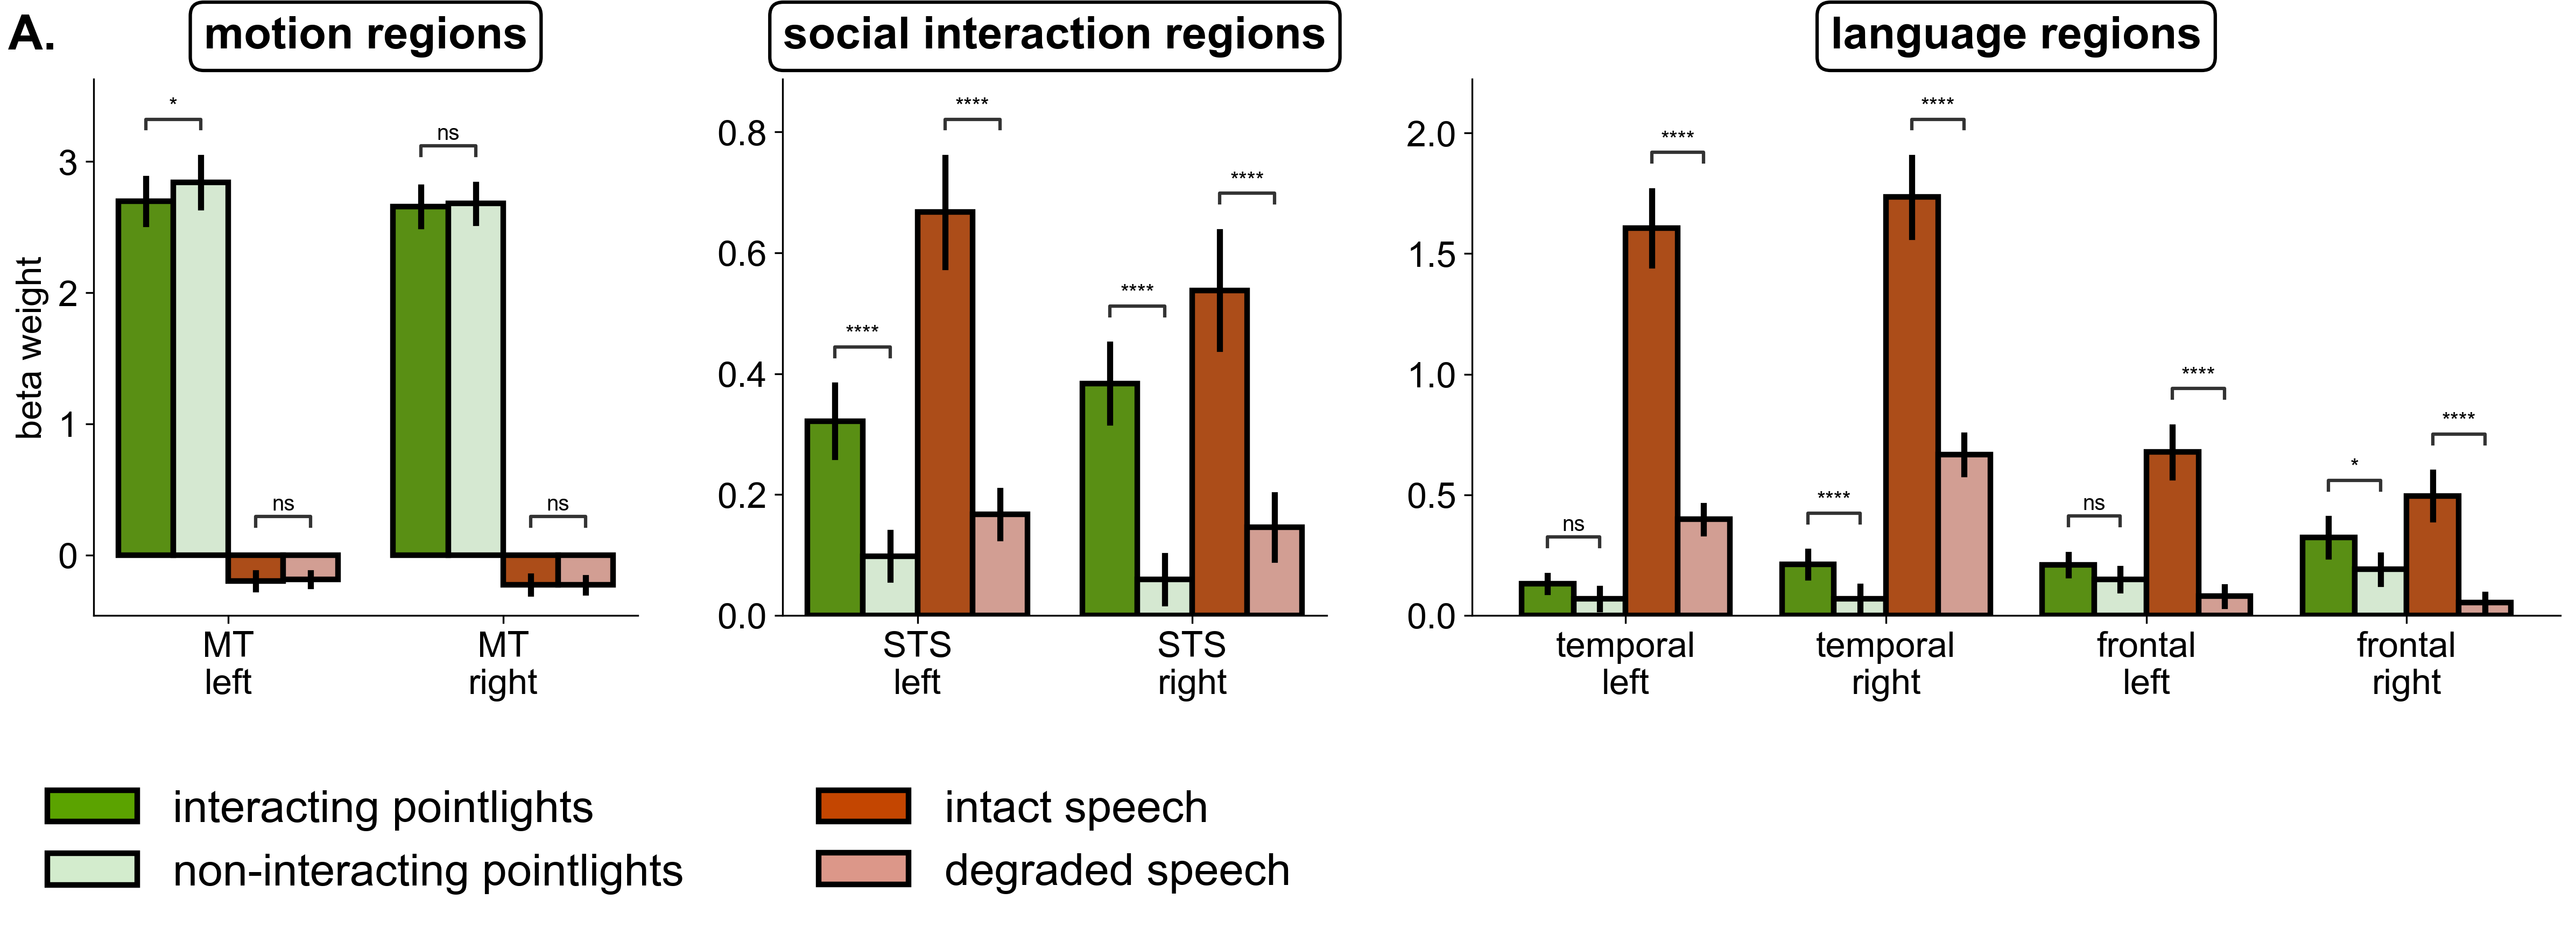

In [47]:
images = []
argument_list = ['smoothing_fwhm','chunklen','mask']
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list]))
images.append(f'{base_filepath}_model-_glm_localizer_glm_response_perc_top_voxels-{args_dict["perc_top_voxels"]}_glm_response_bar.png')
output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'localizer_glm_responses.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=2,label_subplots=True)


### Supplemental Figure 6. Voxelwise responses 

### Supplemental Figure 7. Additional ROI analyses

In [49]:
images = []
argument_list = ['smoothing_fwhm','chunklen','mask']
base_filepath = 'sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list])
images.append(os.path.join(args_dict['figure_dir'],'SecondLevelIndividual',base_filepath+'_model-joint_glm_localizer_enc_response-performance_perc_top_voxels-'+str(args_dict['perc_top_voxels'])+'_bar__.png'))
images.append(os.path.join(args_dict['figure_dir'],'SecondLevelIndividual',base_filepath+'_model-joint_glm_localizer_enc_response-ind_product_measure_perc_top_voxels-'+str(args_dict['perc_top_voxels'])+'_bar_alexnet_vs_language_.png'))
images.append(os.path.join(args_dict['figure_dir'],'SecondLevelIndividual',base_filepath+'_model-vislang_transformers_glm_localizer_enc_response-ind_product_measure_perc_top_voxels-'+str(args_dict['perc_top_voxels'])+'_bar_SimCLR_lang_compiled_.png'))
output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'cross_subject_vis_lang.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=1,label_subplots=True)
print('additional ROI analyses plot saved:',output_filename)


additional ROI analyses plot saved: /Users/hsmall2/Documents/GitHub/naturalistic-multimodal-movie/figures/supplemental/cross_subject_vis_lang.png


### Supplemental Figure 8. AlexNet layerwise predictivity in ROIs and fitted weight similarity.

In [52]:
images = []
argument_list = ['smoothing_fwhm','chunklen','mask']
base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list]))
images.append(f'{base_filepath}_model-joint_glm_localizer_enc_response-ind_product_measure_perc_top_voxels-{args_dict["perc_top_voxels"]}_bar_DNN_layers_alexnet_layers.png')

base_filepath = os.path.join(args_dict['figure_dir'],'SecondLevelIndividual','response_similarity','sub-'+args_dict['population']+'_'+'_'.join([argument.replace('_','')+'-'+str(args_dict[argument]) for argument in argument_list]))
images.append(f'{base_filepath}_model-vislang_weights_response_similarity_perc_top_voxels-{args_dict["perc_top_voxels"]}-alexnet_similarity_matrix_layer6.png')
output_filename = os.path.join(args_dict['dir'],'figures','supplemental',f'AlexNet_split_hemi.png')
plotting_helpers.compose_final_figure(output_filename,images,'',title=None,num_columns=1,label_subplots=True,row_padding_proportion=0.1)
print('alexnet layerwise predictivity and weight similarity figure saved:',output_filename)

alexnet layerwise predictivity and weight similarity figure saved: /Users/hsmall2/Documents/GitHub/naturalistic-multimodal-movie/figures/main/AlexNet_split_hemi.png
